# Imports and Functions

In [1]:
from sunlab.globals import *
from sunlab.environment.base.cpu import *
from sunlab.environment.base.extras import *
from sunlab.common.mathlib.lyapunov import *
from sunlab.sunflow import *

In [2]:
from sklearn.decomposition import PCA as lPCA
from sklearn.decomposition import KernelPCA as PCA

In [3]:
from sklearn.manifold import TSNE

In [4]:
from scipy.signal import correlate2d
from matplotlib import colors

In [5]:
import umap

In [6]:
def fill_between(Y, X=None, alpha=0.15, skip=2, count=4, color='green'):
    from numpy import argsort, diag, array
    if X is None:
        X = range(Y.shape[0])
    if isinstance(Y, list):
        Y = array(Y)
    assert len(Y.shape) == 2
    assert count*(1+skip) < Y.shape[1]//2
    S = argsort(Y, axis=1)
    S_min = S[:,0]
    S_max = S[:,-1]
    Y_nmin = lambda n: diag(Y[:,S[:,n]])
    Y_nmax = lambda n: diag(Y[:,S[:,S.shape[1]-n-1]])
    for i in range(count):
        index = i * (1 + skip)
        plt.gca().fill_between(X, Y_nmin(index), Y_nmax(index), alpha=alpha, color=color)

In [7]:
def find_longest_trajectory(trajectories):
    """# Find longest trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import argmin, argmax, isnan
    N = trajectories.shape[2]
    Longest = 0
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        if Longest < X.shape[0]:
            Longest = X.shape[0]
    return Longest

In [8]:
def autocorrelate_trajectory(trajectories, middle_only=True):
    """# Autocorrelate Trajectory
    trajectories: [Dim, N_t, N]"""
    from numpy import zeros, bool_, argmin, argmax, isnan
    from numpy.ma import masked_where
    N = trajectories.shape[2]
    DimensionSize = 2 * trajectories.shape[0] - 1
    if middle_only:
        DimensionSize = 1
    CorrelationSize = 2 * find_longest_trajectory(trajectories) - 1
    CorrelationMid = trajectories.shape[0] - 1
    Correlation = zeros((CorrelationSize, DimensionSize * N))
    CorrelationMask = zeros((CorrelationSize, DimensionSize * N)).astype(bool_)
    for n in range(N):
        X = trajectories[:,:,n].T # N_t x Dim
        X_max = min(trajectories.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
        X_min = max(argmin(isnan(X), axis=0))
        X = X[X_min:X_max,:]
        correlation = correlate2d(X, X)
        if DimensionSize == 1:
            correlation = correlation[:,[CorrelationMid]]
        C_min = CorrelationSize // 2 - correlation.shape[0] // 2
        C_max = C_min + correlation.shape[0]
        Correlation[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = correlation
        CorrelationMask[C_min:C_max,n*DimensionSize:(n+1)*DimensionSize] = True
    return Correlation, CorrelationMask, masked_where(~CorrelationMask, Correlation)

In [9]:
def plot_autocorrelation(correlation, resolution=1):
    correlation = correlation[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [10]:
def plot_trajectory_autocorrelation(trajectories, resolution=1):
    correlation = autocorrelate_trajectory(trajectories)[2]
    plt.plot(np.linspace(-correlation.shape[0]//2, correlation.shape[0]//2+1, correlation.shape[0])*resolution, correlation)

In [11]:
def shrink(data):
    """# Remove Nans
    data: [D,N_t,N]"""
    from numpy import argmin, argmax, isnan
    X = data[:,:,0].T # N_t x Dim
    X_max = min(data.shape[1] - argmax(~isnan(X[::-1,:]), axis=0))
    X_min = max(argmin(isnan(X), axis=0))
    X = X[X_min:X_max,:]
    return X

In [12]:
def Persistence_t(trajectory, normalize=False):
    """# Persistence
    trajectory: [N_t, Dim]"""
    from numpy.linalg import norm
    from numpy import dot, diag, newaxis
    from numpy.ma import masked_where
    A = trajectory[0:-2,:]
    B = trajectory[1:-1,:]
    C = trajectory[2:, :]
    BA = B - A
    CB = C - B
    if normalize:
        BA_mask = ~masked_where(BA == 0, BA).mask.any(axis=-1)
        CB_mask = ~masked_where(CB == 0, CB).mask.any(axis=-1)
        _mask = BA_mask & CB_mask
        if isinstance(_mask, np.bool_):
            BA = BA
            CB = CB
        else:
            BA = BA[_mask,...]
            CB = CB[_mask,...]
        BA = (BA.T / norm(BA, axis=-1)).T
        CB = (CB.T / norm(CB, axis=-1)).T
        return diag(dot(BA, CB.T)), _mask
    return diag(dot(BA, CB.T))

In [13]:
def Motility_t(trajectory, normalize=False):
    """# Motility
    trajectory: [N_t, 2]

    Assumes the center is at the origin"""
    from numpy.linalg import norm
    from numpy import array, diag, sum
    assert len(trajectory.shape) == 2
    assert trajectory.shape[1] == 2
    A = trajectory[:-1,:]
    B = trajectory[1:,:]
    BA = B - A
    if normalize:
        BA /= norm(BA, axis=-1)
    R = A.copy() # Radial direction for the trajectory
    R = (R.T / np.linalg.norm(R, axis=-1)).T # [N_t,2]
    T = array([R[:,1],-R[:,0]]).T # Tangential direction [N_t,2]
    total_motility = BA.copy() # [N_t, 2]
    radial_motility = (diag(total_motility @ R.T) * R.T).T  # [N_t,2]
    tangential_motility = (diag(total_motility @ T.T) * T.T).T  # [N_t,2]
    return total_motility,radial_motility,tangential_motility

# Runtime Parameters

In [14]:
SAVE_EXTRAS = False

In [15]:
g_Base = lambda *args: f"{DIR_ROOT}/Figures/UMAP/Invasion/ManuallyTracked/"
g_MAX_LAG = 16
g_N_GaussSmooth = 500#250
g_BoxExtra = 2e-2

# Setup

In [16]:
classification_dataset_dict = np.load(DIR_ROOT + "extra_data/ClassificationTestingDataset.npy", allow_pickle=True).item()
classification_dataset = classification_dataset_dict['normalized_dataset']

In [17]:
# model, dataset = load_aae_and_dataset(FILES['TRAINING_DATASET'], FILES['PRETRAINED_MODEL_DIR'], MaxAbsScaler)
# _scaler = model.scaler
_scaler = dataScaler = MaxAbsScaler(DIR_ROOT + "models/current_model/").load()
dataScaler = _scaler

__D = 2
assert __D in [2,3]
model = umap.UMAP(n_components=__D)

#training_dataset = import_10x(FILES['TRAINING_DATASET'], scaler=_scaler)
reduced_dataset = import_10x(FILES['TRAINING_DATASET_WIDE_BERTH'], scaler=_scaler)

In [18]:
dataset_file_name = FILES['TRAINING_DATASET']
model_directory = "../../test_models/umap-2/"
test_dataset_files = [FILES['SPHEROID']['3mgml'],FILES['SPHEROID']['4mgml'],FILES['SPHEROID']['6mgml']]
normalization_scaler = MaxAbsScaler
distribution = GaussianDistribution
magnification = 10
latent_size = 2
batch_size = 1024
shuffle=True
val_split=0.1
autoencoder_depth = 3
use_leaky_relu = False
equal_split = True

In [19]:
trainShapeDataset = ShapeDataset(dataset_file_name, scaler=dataScaler, batch_size=batch_size, shuffle=True, val_split=val_split,equal_split=equal_split)

In [20]:
test_datasets = [import_dataset(dataset, magnification, scaler=dataScaler) for dataset in test_dataset_files]
test_dataset = np.vstack([test_dataset.dataset for test_dataset in test_datasets])

In [21]:
training_dataset = dataScaler(trainShapeDataset.training_data)
validation_dataset = dataScaler(trainShapeDataset.validation_data)

In [22]:
import timeit

In [23]:
training_data = []
training_classification_data = []

In [24]:
from tqdm.auto import tqdm

In [38]:
for n_tests in tqdm(range(12)):
    start_time = timeit.default_timer()
    model = umap.UMAP(n_components=__D).fit(training_dataset)
    elapsed_train = timeit.default_timer() - start_time
    start_time = timeit.default_timer()
    run_this = model.inverse_transform(model.transform(trainShapeDataset.dataset))
    elapsed_inference = timeit.default_timer() - start_time
    ae_t = np.abs(model.inverse_transform(model.transform(training_dataset)) - training_dataset)
    ae_v = np.abs(model.inverse_transform(model.transform(validation_dataset)) - validation_dataset)
    ae_T = np.abs(model.inverse_transform(model.transform(test_dataset)) - test_dataset)
    mae_t = np.mean(ae_t)
    mae_v = np.mean(ae_v)
    mae_T = np.mean(ae_T)
    rmse_t = np.mean((np.mean(ae_t ** 2., axis=-1)) ** (1./2.))
    rmse_v = np.mean((np.mean(ae_v ** 2., axis=-1)) ** (1./2.))
    rmse_T = np.mean((np.mean(ae_T ** 2., axis=-1)) ** (1./2.))
    rmpe_t = np.mean((np.mean(ae_t ** 13., axis=-1)) ** (1./13.))
    rmpe_v = np.mean((np.mean(ae_v ** 13., axis=-1)) ** (1./13.))
    rmpe_T = np.mean((np.mean(ae_T ** 13., axis=-1)) ** (1./13.))
    training_data.append((-1, -1, -1, elapsed_train, elapsed_inference,
                 mae_t, mae_v, mae_T,
                 rmse_t, rmse_v, rmse_T,
                 rmpe_t, rmpe_v, rmpe_T))
    training_classification_data.append(
        dataScaler.scaler.inverse_transform(model.inverse_transform(model.transform(classification_dataset)))
    )

  0%|          | 0/12 [00:00<?, ?it/s]

In [39]:
np.array(training_classification_data).shape

(12, 15834, 13)

In [40]:
assert False, "Don't overwrite"
np.save(f"../../classification_results_umap.npy", dict(results=np.array(training_classification_data)))

In [ ]:
assert False, "Don't overwrite"
np.save(f"../../results_three_umap.npy", dict(results=training_data))

In [ ]:
training_data

In [24]:
model = umap.UMAP(n_components=__D).fit(training_dataset)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [25]:
__D

2

# Depth Checking

In [26]:
from scipy.spatial import KDTree

In [27]:
dataset = trainShapeDataset

In [28]:
latent_vectors = model.transform(dataset.dataset)
latent_vectors.shape

(19479, 2)

In [29]:
tree = KDTree(latent_vectors)

In [30]:
R = np.inf
# R = 0.05 # np.inf
N = 13*2 # latent_vectors.shape[0]
# N = 4 # latent_vectors.shape[0]

In [31]:
res = [tree.query(latent_vectors[dataset.labels==phenotype], N, distance_upper_bound=R) for phenotype in range(4)]

In [32]:
from tqdm.auto import tqdm

In [33]:
phenotype_neighbors = dict()
for phenotype in tqdm(range(4)):
    cells = np.argwhere(dataset.labels == phenotype)
    dists, indxs = res[phenotype]

    neighbors = {i: 0 for i in range(4)}
    for row in range(dists.shape[0]):
    #     cell = cells[row]
        classes = dataset.labels[indxs[row,~np.isinf(dists[row,...]).squeeze()]].astype(np.uint8)
        phenotypes, counts = np.unique(classes, return_counts=True)
        for i in range(phenotypes.shape[0]):
            neighbors[int(phenotypes[i])] += counts[i]

    phenotype_neighbors[phenotype] = neighbors
phenotype_neighbors

  0%|          | 0/4 [00:00<?, ?it/s]

{0: {0: 42010, 1: 4309, 2: 12840, 3: 16969},
 1: {0: 4197, 1: 89976, 2: 2768, 3: 15327},
 2: {0: 12997, 1: 2676, 2: 121009, 3: 11908},
 3: {0: 16915, 1: 15747, 2: 12190, 3: 124616}}

In [34]:
phenotype_names = ['ActinEdge', 'Filopodia', 'Bleb', 'Lamellipodia']

In [35]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    r = counts[phenotype]/sum(counts)
    print(counts)
    print(r*100)

ActinEdge
[42010, 4309, 12840, 16969]
55.1833753678016
Filopodia
[4197, 89976, 2768, 15327]
80.14394128335768
Bleb
[12997, 2676, 121009, 11908]
81.43818561141396
Lamellipodia
[16915, 15747, 12190, 124616]
73.53364647013005


In [36]:
for phenotype in range(4):
    print(phenotype_names[phenotype])
    counts = list(phenotype_neighbors[phenotype].values())
    fixed_normalization = (2*counts[phenotype]-sum(counts))/N
    phenotype_relative_normalization = (2*counts[phenotype]-sum(counts))/np.sum(dataset.labels==phenotype)
    print(counts)
    print(fixed_normalization)
    print(phenotype_relative_normalization)

ActinEdge
[42010, 4309, 12840, 16969]
303.53846153846155
2.6953551912568305
Filopodia
[4197, 89976, 2768, 15327]
2603.230769230769
15.674849467345993
Bleb
[12997, 2676, 121009, 11908]
3593.3846153846152
16.34785651793526
Lamellipodia
[16915, 15747, 12190, 124616]
3067.846153846154
12.237496164467627


In [45]:
SAVE_EXTRAS=False
g_Base = lambda *args: DIR_ROOT + "Figures/UMAP/Invasion/"

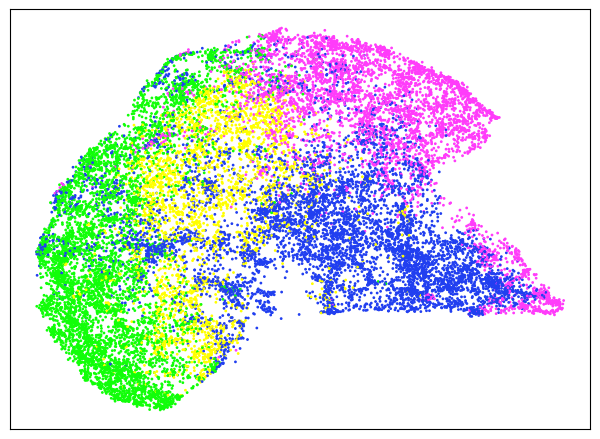

In [44]:
plt.scatter2d(latent_vectors, c=dataset.labels, cmap=Pmap, s=1)
if SAVE_EXTRAS:
    plt.save(g_Base() + "UMAP")

# END